<a href="https://colab.research.google.com/github/RIZKYANGKATA/MACHLEARN/blob/main/Modul_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*PRAKTIKUM 1*

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'This is John Waters best film to date. The characters are obvious and symbolic, just as in his other films. So there are no surprises or character changes. I enjoyed the film because of the wittiness and pace of the story. It was good story-telling with honest people.'
 b"PROM NIGHT (2008)<br /><br />directed by: Nelson McCormick<br /><br />starring: Brittany Snow, Scott Porter, Jessica Stroup, and Dana Davis<br /><br />plot: Three years ago, Donna (Brittany Snow) witnessed the death of her entire family at the hands of her teacher (Jonathan Schaech) who has a bit of a crush on her. Now, she is preparing for her senior prom with her stupid annoying friends. Once there, they start dying one by one because the killer escaped from prison and no one bothered to warn Donna because apparently her prom is too important to interrupt. <br /><br />pros: I got a few good laughs out of the film due to the terrible dialog and the dumb character moves.<br /><br />An example:<br /><br />Ev

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7, 298, ...,   0,   0,   0],
       [  1, 311,   1, ...,   0,   0,   0],
       [ 10,   1,  58, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This is John Waters best film to date. The characters are obvious and symbolic, just as in his other films. So there are no surprises or character changes. I enjoyed the film because of the wittiness and pace of the story. It was good story-telling with honest people.'
Round-trip:  this is john [UNK] best film to [UNK] the characters are obvious and [UNK] just as in his other films so there are no [UNK] or character [UNK] i enjoyed the film because of the [UNK] and [UNK] of the story it was good [UNK] with [UNK] people                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00321618]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 347ms/step
[-0.00321618]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 724s 2s/step - loss: 0.6325 - accuracy: 0.5776 - val_loss: 0.4705 - val_accuracy: 0.7437
Epoch 2/10
391/391 [==============================] - 702s 2s/step - loss: 0.3864 - accuracy: 0.8244 - val_loss: 0.3652 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 689s 2s/step - loss: 0.3349 - accuracy: 0.8526 - val_loss: 0.3367 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 698s 2s/step - loss: 0.3189 - accuracy: 0.8620 - val_loss: 0.3290 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 710s 2s/step - loss: 0.3133 - accuracy: 0.8664 - val_loss: 0.3288 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 709s 2s/step - loss: 0.3094 - accuracy: 0.8654 - val_loss: 0.3254 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 720s 2s/step - loss: 0.3046 - accuracy: 0.8691 - val_loss: 0.3211 - val_accuracy: 0.8583

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 161s 413ms/step - loss: 0.3246 - accuracy: 0.8626
Test Loss: 0.32456159591674805
Test Accuracy: 0.862559974193573


(0.0, 0.64919004291296)

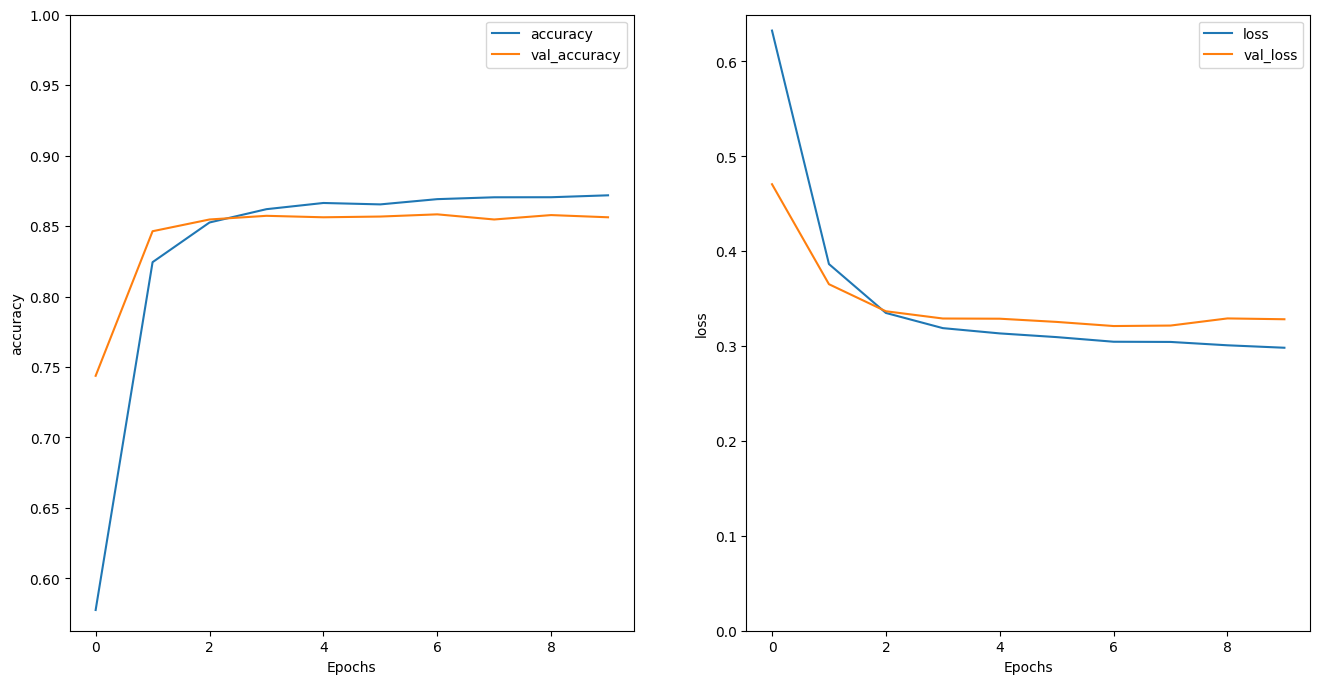

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1417s 4s/step - loss: 0.6159 - accuracy: 0.6096 - val_loss: 0.4366 - val_accuracy: 0.8193
Epoch 2/10
391/391 [==============================] - 1366s 3s/step - loss: 0.3950 - accuracy: 0.8283 - val_loss: 0.3641 - val_accuracy: 0.8380
Epoch 3/10
391/391 [==============================] - 1372s 4s/step - loss: 0.3405 - accuracy: 0.8535 - val_loss: 0.3330 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 1331s 3s/step - loss: 0.3203 - accuracy: 0.8641 - val_loss: 0.3384 - val_accuracy: 0.8385
Epoch 5/10
391/391 [==============================] - 1320s 3s/step - loss: 0.3119 - accuracy: 0.8676 - val_loss: 0.3318 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 1305s 3s/step - loss: 0.3085 - accuracy: 0.8688 - val_loss: 0.3277 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 1306s 3s/step - loss: 0.3013 - accuracy: 0.8726 - val_loss: 0.3236 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 299s 764ms/step - loss: 0.3183 - accuracy: 0.8520
Test Loss: 0.3182699680328369
Test Accuracy: 0.8519600033760071


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 9s 9s/step
[[-1.6177932]]


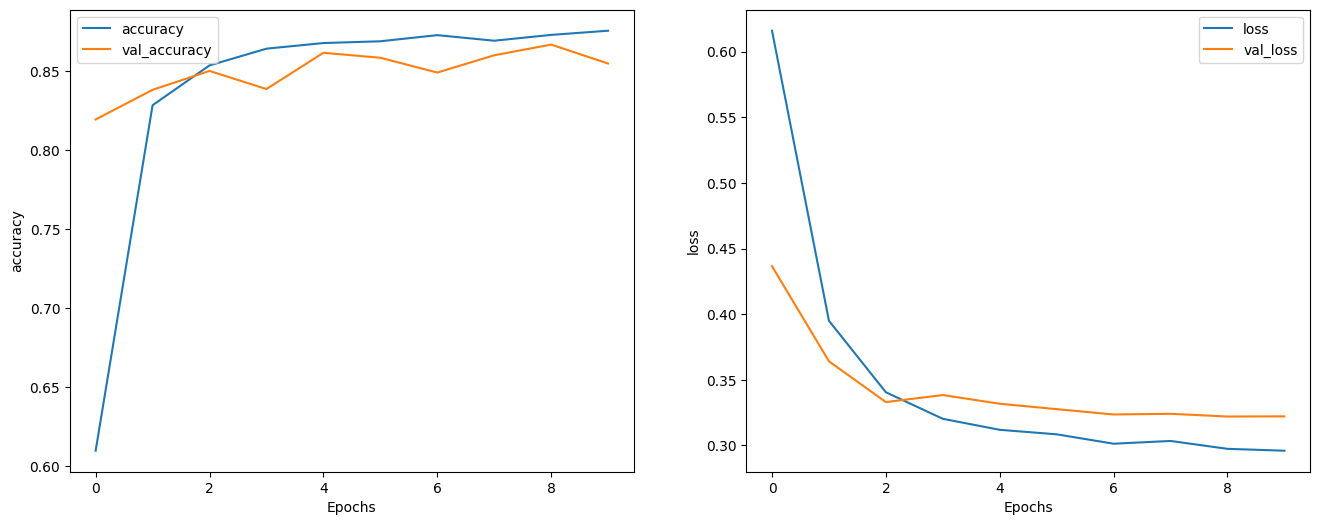

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

*PRAKTIKUM 2*

In [1]:
import tensorflow as tf
import numpy as np
import os
import time

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [5]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [6]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [7]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [8]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [9]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [10]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [11]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [12]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [13]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [14]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [15]:
seq_length = 100

In [16]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [17]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [18]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [19]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [20]:
dataset = sequences.map(split_input_target)

In [21]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [22]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [23]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [24]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [25]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [26]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [27]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [29]:
sampled_indices

array([25, 41, 25, 63,  6, 52, 52,  1, 13, 43, 15, 49,  3, 49, 60,  3, 62,
       39, 65, 50, 34,  3, 32, 54, 42, 13, 41, 28, 28, 12,  1, 22, 52, 18,
       57, 11, 35, 26, 48,  3, 52, 37, 41, 38, 15, 64, 28, 24, 62, 39, 21,
       42,  8, 11, 10, 30, 64, 42, 33, 10,  9, 46, 55, 12, 13, 43, 55,  4,
       39, 20, 50, 19, 58, 17, 22, 64, 54,  8, 35,  7, 40, 18, 50,  9, 18,
       28, 16, 65, 22, 50, 43, 11, 32, 24, 21, 29, 10, 40,  0, 60])

In [30]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"icious woman,\nCompact with her that's gone, think'st thou thy oaths,\nThough they would swear down ea"

Next Char Predictions:
 b"LbLx'mm\n?dBj!ju!wZzkU!Soc?bOO;\nImEr:VMi!mXbYByOKwZHc-:3QycT3.gp;?dp$ZGkFsDIyo-V,aEk.EOCzIkd:SKHP3a[UNK]u"


In [31]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190283, shape=(), dtype=float32)


In [33]:
tf.exp(example_batch_mean_loss).numpy()

66.041466

In [34]:
model.compile(optimizer='adam', loss=loss)

In [35]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [36]:
EPOCHS = 20

In [37]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 662s 4s/step - loss: 2.7204
Epoch 2/20
172/172 [==============================] - 649s 4s/step - loss: 1.9909
Epoch 3/20
172/172 [==============================] - 647s 4s/step - loss: 1.7108
Epoch 4/20
172/172 [==============================] - 646s 4s/step - loss: 1.5494
Epoch 5/20
172/172 [==============================] - 646s 4s/step - loss: 1.4499
Epoch 6/20
172/172 [==============================] - 647s 4s/step - loss: 1.3814
Epoch 7/20
172/172 [==============================] - 646s 4s/step - loss: 1.3283
Epoch 8/20
172/172 [==============================] - 647s 4s/step - loss: 1.2840
Epoch 9/20
172/172 [==============================] - 644s 4s/step - loss: 1.2442
Epoch 10/20
172/172 [==============================] - 643s 4s/step - loss: 1.2041
Epoch 11/20
172/172 [==============================] - 644s 4s/step - loss: 1.1640
Epoch 12/20
172/172 [==============================] - 644s 4s/step - loss: 1.1238
Epoch 13/20
1

In [38]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [39]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [40]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
I say how thwalter'd Murderer:
Rather can I never be revenged from friend:
Like a bold spilt beseeming in his meddless'd,
For firmis his father be in process
Of who shouldst keep his eye as doughly seal down
Resigned eyes shallow the venour chance to-morrow.
Hark! the king comes! Friar London, tyrrel,
But meet her kindled, it would bedeach it.

QUEEN MARGARET:
Thy death, crush of this place Lady Targenes, and so good,
Is come to have a thousand swords.

BENVOLIO:
Roundly lamente!' but he's done, so bright in this;
I will not part you fit to help me soundly
To be revenged on him.

BUCKINGHAM:
I am the voy of this first here, there should be hung
And blow the heart of special prince,
And says he wame, until I be your foe.

MARIINA:
I know; you're a noble ancestor;
And of those cry of that death unto a rock, I pray.

TRANIO:
Why, she's a lawful as any if you be ready,
Till I will appear thine of the death of other:
Glouge can we now stay undertake thy love,
That you shall find out 

In [41]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThe cellars thigh, by my revenge husband,\nAnd pluck the majmst the Dulf was proof, Jalies!\nWhat he doth make, some fearful empty exarl.\n\nHASTINGS:\nI tender happy then, and I'll stay all\nyour power; back-born! comes what I bone\nTo real our person which starve with thee\nAs thou lovest in his foe; for once of man,\nFrom conveyance in himself which in her chase of us\nAnd like an extreme pass of the news.\n\nCORIOLANUS:\nGo to! no more: my father\nWas too intended to be his choices?\n\nCATESBY:\nMadam, if you be he, Biondello?\n\nBIONDELLO:\nI cannot do to him: 'Tis pastly told.\n\nKING RICHARD III:\nThen, dreadful namish me, this must what thou hast been\nwiped my authonity, your honour hath Bore men\nIf being Romeo: you have made wearing Jehamb,\nAnd thou but duty and made him may: I beseech you\nwhen I was a poor winted's champion's wife's insolence?\nAt thy good nays both, if it be innocent.\nI was your grace Lad's warm thee to a\ngreat garden--on thy bed,

In [42]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [43]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
I am the child, he stull upon the fard
Of power: I will prove Vincention, does!
Save thine! And if 


*Tugas Praktikum*